# How-To: Use Deep Learning models with eo-learn
This notebook shows how deep learning algorithms can be used inside an eo-learn workflow to perform a crop field identification task.

## Before you start
### Requirements

* This notebook doesn't describe how to train a neural network but rather how it is possible to integrate an already trained one inside a workflow to perform some kind of processing. This exemple use a RefineNet[1] model that was trained to produce semantic segmentation of cultivated area from Sentinel-2 images.


* In order to run the example you’ll need a configured Sentinel Hub account (see the [configuration instructions](https://sentinelhub-py.readthedocs.io/en/latest/configure.html) if necessary)

* This neural network was trained using the [Pytorch](https://pytorch.org/) framework and need to be installed. You can do so by using: 
``` shell
pip install torch===1.4.0
``` 

### Overview
This notebook is divided in 3 sections:
 1. Defining the required EO-task 
 2. Visualizing the results
 3. Computing statistics

[1]: Lin, G., Milan, A., Shen, C., & Reid, I. (2017, juillet). RefineNet: Multi-path Refinement Networks for High-Resolution Semantic Segmentation. 5168‑5177. https://doi.org/10.1109/CVPR.2017.549

## 1.Defining the required EO-task

For this task we will use a shapefile containing all the crop fields in Austria during 2016 as an exemple:

In [1]:
import geopandas as gpd

austria_lpis_2016 = gpd.read_file('../../PerSenDatasetEval/input_data/INSPIRE_SCHLAEGE_2016.shp')
austria_lpis_2016.head()

,FS_KENNUNG,SNAR_BEZEI,SL_FLAECHE,KG_NR,KG_NAME,geometry
0,56237696.0,KRNERMAIS,2.405292,66002.0,Arnfels,"POLYGON ((15.40109226383048 46.6807966596994, ..."
1,56237701.0,GRNBRACHE,1.168324,63262.0,Oberpremsttten,"POLYGON ((15.39290467557251 46.97952180785489,..."
2,56237705.0,KRNERMAIS,0.764013,66036.0,Saggau,"POLYGON ((15.3950022566063 46.6879047357612, 1..."
3,56237710.0,KRNERMAIS,2.684438,66002.0,Arnfels,"POLYGON ((15.39507894085918 46.68042360666715,..."
4,56237716.0,KRNERMAIS,2.355382,66016.0,Kitzelsdorf,"POLYGON ((15.39239116140408 46.67917854817072,..."


Each entry from the shapefile contains a polygon defining a field in Austria with its crop type within the **SNAR_BEZEI** field.

We want to see if our model can predict the cultivated area around these fields based on Sentinel-2 data. We need some EO-Task that extracts location informations from the polygon:

In [2]:
from eolearn.core import EOPatch, FeatureType, EOTask
from sentinelhub.areas import BBox
from sentinelhub.constants import CRS

class InitEOPatch(EOTask):
    def __init__(self, time_interval):
        # Time interval for the Sentinel-2 data
        self.time_interval = time_interval
    
    def execute(self, polygon):
        geometry = polygon.buffer(0.005)
        
        # Get Bounding box of the polygon
        envelope = geometry.envelope.geometry[geometry.envelope.geometry.keys().tolist()[0]]
        bbox = BBox(envelope, crs=CRS.WGS84)
        
        # Store the data inside the EOPatch
        eopatch = EOPatch()
        eopatch.vector_timeless['polygon'] = polygon
#         eopatch.vector_timeless['polygon'] = gpd.GeoDataFrame(polygon, crs={'init' :'WGS84'})
        eopatch.meta_info['time_interval'] = self.time_interval
        eopatch.bbox = bbox
        return eopatch

# Initialise the task for data taken suring the 2016 summer
init_task = InitEOPatch(('2016-02-01', '2016-10-31'))

#Display an example from one polygon:
example_patch = init_task.execute(austria_lpis_2016[100:101])
display(example_patch)

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    polygon: geopandas.GeoDataFrame(columns=['FS_KENNUNG', 'SNAR_BEZEI', 'SL_FLAECHE', 'KG_NR', 'KG_NAME', 'geometry'], length=1, crs=epsg:4326)
  }
  meta_info: {
    time_interval: ('2016-02-01', '2016-10-31')
  }
  bbox: BBox(((15.038997728974897, 48.08154102693972), (15.051376652921679, 48.09265058732142)), crs=EPSG:4326)
  timestamp: []
)

We now need to download Sentinel-2 data in the time interval:

In [3]:
from eolearn.io import S2L1CWCSInput
import matplotlib.pyplot as plt
import numpy as np
import rasterio.features
import math

# Normalise the image array for better colour visualisation
def normalize_percentile(image, percentile):
    if (np.percentile(image, 100 - percentile) - np.percentile(image, percentile)) != 0:
        return np.clip((image - np.percentile(image, percentile)) /
                       (np.percentile(image, 100 - percentile) -
                        np.percentile(image, percentile))*255, 0, 255).astype(np.uint8)
    else:
        return np.zeros_like(image)

# Download the images
input_task = S2L1CWCSInput(layer='BANDS-S2-L1C', resx='10m', resy='10m', maxcc=0.2)
example_patch = input_task.execute(example_patch)

# Get the images array
images = example_patch.data['BANDS-S2-L1C'][:,:,:,[3,2,1]]

# Overlay the polygon by rasterising it:
bbox_poly = example_patch.bbox.get_geometry()
geomtrie = example_patch.vector_timeless['polygon']
filtered_data = geomtrie[geomtrie.intersects(bbox_poly)].copy(deep=True)
filtered_data.geometry = filtered_data.geometry.intersection(bbox_poly).exterior
height, width = example_patch.get_spatial_dimension(FeatureType.MASK, 'IS_DATA')
data_transform = rasterio.transform.from_bounds(*example_patch.bbox, width=width, height=height)
raster = np.zeros_like(example_patch.mask['IS_DATA'][0].squeeze()).astype(np.uint8)
rasterio.features.rasterize([(filtered_data.cascaded_union, 255)], out=raster, transform=data_transform, dtype=np.uint8)

# Display all images
fig = plt.figure(figsize=(8, 8))
for i, image in enumerate(images):
    ax = plt.subplot(math.ceil(images.shape[0]/3), 3, i + 1)
    image = normalize_percentile(image, 2)
    # Display the polygon in red
    image[raster==255] = [255, 0, 0]
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
fig.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()
print(example_patch)

EOPatch(
  data: {
    BANDS-S2-L1C: numpy.ndarray(shape=(9, 124, 92, 13), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(9, 124, 92, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    polygon: geopandas.GeoDataFrame(columns=['FS_KENNUNG', 'SNAR_BEZEI', 'SL_FLAECHE', 'KG_NR', 'KG_NAME', 'geometry'], length=1, crs=epsg:4326)
  }
  meta_info: {
    maxcc: 0.2
    service_type: 'wcs'
    size_x: '10m'
    size_y: '10m'
    time_difference: datetime.timedelta(-1, 86399)
    time_interval: ('2016-02-01', '2016-10-31')
  }
  bbox: BBox(((15.038997728974897, 48.08154102693972), (15.051376652921679, 48.09265058732142)), crs=EPSG:4326)
  timestamp: [datetime.datetime(2016, 3, 17, 10, 6, 59), ..., datetime.datetime(2016, 9, 23, 10, 6, 25)], length=9
)


We can now run our deep learning model on Sentinel-2 data:

We need to setup a few EO-Tasks to prepare the data and run the model inference:

In [4]:
import torch
from models.model_RefineNet import build_refinenet
from models.model_ResNet import build_resnet

class DeepEval(EOTask):
    def __init__(self, feature, model_dir, gpu_mode=True):
        '''
        feature: EO-Patch feature to use for the inference
        model_dir: Path to the model to load
        gpu_mode: Whether to use the GPU for the inference
        '''
        self.feature = self._parse_features(feature, new_names=True,
                                            default_feature_type=FeatureType.DATA,
                                            rename_function='{}_CROP_MASK'.format)
        self.model_dir = model_dir
        self.GPU_MODE = gpu_mode
        if not self.GPU_MODE:
            self.device = 'cuda:0'
        else:
            self.device = 'cpu'
        encoder, down_factors = build_resnet(nb_layers=101, in_channels=13, encoder_only=True)
        model = build_refinenet(4, 4, [128, 256, 512, 1024, 2048], 2, encoder, down_factors, nb_pool_block=4,
                                activation='lrelu', bn=True).to(self.device)

        checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)
        model.load_state_dict(checkpoint['model_state_dict'])
        self.model = model.eval()

    def execute(self, eopatch):
        if eopatch is None:
            return None
        else:
            eval = []
            eval_one_hot = []
            eval_proba = []
            feature_type, feature_name, new_feature_name = next(self.feature(eopatch))
            with torch.no_grad():
                for i, im in enumerate(eopatch[feature_type][feature_name]):
                    try:
                        input_tensor = torch.from_numpy(np.rollaxis(im, 2, 0)).unsqueeze(0).to(self.device).float() * 10000 / 32768
                        padw = 224 - input_tensor.size(3)
                        padh = 224 - input_tensor.size(2)
                        input_tensor = torch.nn.ConstantPad2d((int(padw/2), (padw - int(padw/2)), int(padh/2), (padh - int(padh/2))), 0)(input_tensor)
                        out = self.model(input_tensor)[0, [0]]
                        out = out[:, int(padh/2):-(padh - int(padh/2)), int(padw/2):-(padw - int(padw/2))]

                        thresh = 0.36
                        mask_one_hot = torch.nn.Threshold(thresh, 0)(out)
                        mask_one_hot[mask_one_hot > 0] = 1
                        mask_one_hot = mask_one_hot.cpu().numpy()[0].astype(np.uint8)

                         # Clip probabilities to [0-255]
                        out = out.cpu().numpy()
                        out *= 255.
                        out = np.clip(out, 0., 255.)
                        out = np.rollaxis(out.astype(np.uint8), 0, 3)

                        mask = np.zeros(mask_one_hot.shape + (3,))
                        mask[mask_one_hot>0] = [255, 255, 255]
                        mask = mask.astype(np.uint8)
                        if i == 0:
                            eval = np.array([mask])
                            eval_one_hot = np.array([mask_one_hot])
                            eval_proba = np.array([out])
                        else:
                            eval = np.append(eval, np.array([mask]), axis=0)
                            eval_one_hot = np.append(eval_one_hot, np.array([mask_one_hot]), axis=0)
                            eval_proba = np.append(eval_proba, np.array([out]), axis=0)
                    except Exception as exception:
                        print(exception)
            eopatch.mask[new_feature_name] = eval
            eopatch.mask[new_feature_name + '_CLASS'] = eval_one_hot.reshape(eval_one_hot.shape + (1,))
            eopatch.mask[new_feature_name + '_PROBA'] = eval_proba
            eopatch.meta_info['class_rgb'] = [255, 255, 255]
            eopatch.meta_info['class_labels'] = ['Field']
            return eopatch

In [5]:
model_path='/media/data_deep/DATA_H2020_PERSEN/output/output_border/run_20/model.pth'
eval_task = DeepEval((FeatureType.DATA, 'BANDS-S2-L1C', 'MODEL_EVAL'), model_path, gpu_mode=True)

example_patch = eval_task.execute(example_patch)
display(example_patch)

EOPatch(
  data: {
    BANDS-S2-L1C: numpy.ndarray(shape=(9, 124, 92, 13), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(9, 124, 92, 1), dtype=bool)
    MODEL_EVAL: numpy.ndarray(shape=(9, 124, 92, 3), dtype=uint8)
    MODEL_EVAL_CLASS: numpy.ndarray(shape=(9, 124, 92, 1), dtype=uint8)
    MODEL_EVAL_PROBA: numpy.ndarray(shape=(9, 124, 92, 1), dtype=uint8)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    polygon: geopandas.GeoDataFrame(columns=['FS_KENNUNG', 'SNAR_BEZEI', 'SL_FLAECHE', 'KG_NR', 'KG_NAME', 'geometry'], length=1, crs=epsg:4326)
  }
  meta_info: {
    class_labels: ['Field']
    class_rgb: [255, 255, 255]
    maxcc: 0.2
    service_type: 'wcs'
    size_x: '10m'
    size_y: '10m'
    time_difference: datetime.timedelta(-1, 86399)
    time_interval: ('2016-02-01', '2016-10-31')
  }
  bbox: BBox(((15.038997728974897, 48.08154102693972), (15.051376652921679, 4

We can visualize the output:

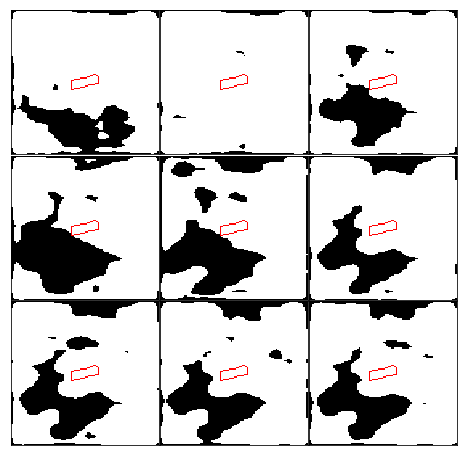

In [6]:
# Get the evaluations
masks = example_patch.mask['MODEL_EVAL']

# Display all evaluations
fig = plt.figure(figsize=(8, 8))
for i, mask in enumerate(masks):
    ax = plt.subplot(math.ceil(masks.shape[0]/3), 3, i + 1)
    # Display the polygon in red
    mask[raster==255] = [255, 0, 0]
    plt.imshow(mask)
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
fig.subplots_adjust(wspace=0.01, hspace=0.01)

We can now average all the predictions in a single one to extract the crop type:

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: FeatureType.MASK_TIMELESS is a discrete feature type therefore dtype of data should be a subtype of numpy.integer or numpy.bool, found type <class 'numpy.float64'>. In the future an error will be raised becauseof this
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: FeatureType.MASK_TIMELESS is a discrete feature type therefore dtype of data should be a subtype of numpy.integer or numpy.bool, found type <class 'numpy.float64'>. In the future an error will be raised becauseof this


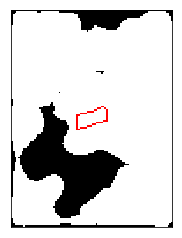

In [7]:
# We extract the average prediction ignoring background and clouds
class SumPrediction(EOTask):
    def __init__(self, feature, classes_to_ignore=np.asarray([]), threshold=0.5):
        self.feature = self._parse_features(feature, new_names=True,
                                            default_feature_type=FeatureType.DATA,
                                            rename_function='{}_ALL-TIME'.format)
        self.classes_to_ignore = classes_to_ignore
        self.threshold = threshold
        
    def execute(self, eopatch):
        feature_type, feature_name, new_feature_name = next(self.feature(eopatch))
        prediction = eopatch[feature_type][feature_name].sum(axis=0) / len(eopatch.timestamp)
        eopatch.mask_timeless[new_feature_name+'_PROBA'] = prediction.copy()
        thresh = 0.36 * 255
        prediction[prediction<=thresh] = 0
        prediction[prediction>thresh] = 1
        eopatch.mask_timeless[new_feature_name] = prediction.copy()
        prediction=prediction[:,:,0]
        
        mask = np.zeros(prediction.shape + (3,))
        mask[prediction>0] = [255, 255, 255]
        prediction = mask.astype(np.uint8)
        eopatch.mask_timeless[new_feature_name+'_MASK'] = prediction
        return eopatch

prediction_task = SumPrediction((FeatureType.MASK, 'MODEL_EVAL_PROBA', 'ALL-TIME_PREDICTION'), classes_to_ignore=np.asarray([1]), threshold=0.5)
example_patch = prediction_task.execute(example_patch)

prediction = example_patch.mask_timeless['ALL-TIME_PREDICTION_MASK']
prediction[raster==255] = [255, 0, 0]
plt.figure()
plt.imshow(prediction)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.show()

This prediction can now be used to extract the most present information inside the polygon and finally get a prediction to compare with the ground truth

In [8]:
class Rasterize(EOTask):
    def __init__(self, polygon_feature, feature, raster_shape, raster_value):
        self.raster_value = raster_value
        self.raster_shape_type, self.raster_shape_name = raster_shape
        self.feature_type, self.feature_name = feature
        self.polygon_type, self.polygon_name = polygon_feature
        
    def execute(self, eopatch):
        shape = eopatch[self.raster_shape_type][self.raster_shape_name][0,:,:,0].shape
        raster_filled = rasterio.features.rasterize(eopatch[self.polygon_type][self.polygon_name].geometry, out_shape=shape, transform=rasterio.transform.from_bounds(*eopatch.bbox, height=shape[0], width=shape[1]), default_value=self.raster_value)
        eopatch[self.feature_type][self.feature_name] = np.expand_dims(raster_filled, axis=-1)
        return eopatch
    
class ExtractField(EOTask):
    def __init__(self):
        pass
    
    def execute(self, eopatch):
        eval_in_shape = eopatch.mask_timeless['ALL-TIME_PREDICTION'][np.all(eopatch.mask_timeless['CLASS_MASK'] == 255, axis=-1)]
        if len(eval_in_shape) > 0 and (eval_in_shape.shape[0] > 1):
                if eval_in_shape.shape[-1] == 1:
                    eval_in_shape = eval_in_shape.squeeze()
                found = np.unique(eval_in_shape, axis=0, return_counts=True)
                if len(found) == 2 and len(found[0]) > 0 and len(found[1]) > 0:
                    most_present_class = found[0][np.argmax(found[1])]
                    if most_present_class == 1:
                        eopatch.meta_info['FOUND_LABEL'] = eopatch.meta_info['class_labels'][0]
                    else:
                        eopatch.meta_info['FOUND_LABEL'] = 'Background'
                else:
                    eopatch.meta_info['FOUND_LABEL'] = 'Background'
        else:
            eopatch.meta_info['FOUND_LABEL'] = 'Background'
        return eopatch
    
rasterize_gt_task = Rasterize((FeatureType.VECTOR_TIMELESS, 'polygon'), (FeatureType.MASK_TIMELESS, 'CLASS_MASK'), (FeatureType.MASK, 'IS_DATA'), 255)
example_patch = rasterize_gt_task.execute(example_patch)

extract_field_task = ExtractField()
example_patch = extract_field_task.execute(example_patch)
display(example_patch)

EOPatch(
  data: {
    BANDS-S2-L1C: numpy.ndarray(shape=(9, 124, 92, 13), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(9, 124, 92, 1), dtype=bool)
    MODEL_EVAL: numpy.ndarray(shape=(9, 124, 92, 3), dtype=uint8)
    MODEL_EVAL_CLASS: numpy.ndarray(shape=(9, 124, 92, 1), dtype=uint8)
    MODEL_EVAL_PROBA: numpy.ndarray(shape=(9, 124, 92, 1), dtype=uint8)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    ALL-TIME_PREDICTION: numpy.ndarray(shape=(124, 92, 1), dtype=float64)
    ALL-TIME_PREDICTION_MASK: numpy.ndarray(shape=(124, 92, 3), dtype=uint8)
    ALL-TIME_PREDICTION_PROBA: numpy.ndarray(shape=(124, 92, 1), dtype=float64)
    CLASS_MASK: numpy.ndarray(shape=(124, 92, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    polygon: geopandas.GeoDataFrame(columns=['FS_KENNUNG', 'SNAR_BEZEI', 'SL_FLAECHE', 'KG_NR', 'KG_NAME', 'geometry'], length=1, crs=epsg:4326)
  }
  meta_info: {
    FOUND_LABEL: 

We can see in the **FOUND_LABEL** field that the predicted type is indeed **Field**.

## 2. Visualization

Finally we can join all thoses tasks inside a workflow to easily use all the previously defined tasks on any polygon:

In [9]:
from eolearn.core import LinearWorkflow

workflow = LinearWorkflow(init_task,
                           input_task,
                           eval_task,
                           prediction_task,
                           rasterize_gt_task,
                           extract_field_task) 

polygon = austria_lpis_2016[2220:2221]
patch = workflow.execute({
            init_task: {'polygon': polygon}
        })
for x in patch.keys():
    patch = patch[x]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: FeatureType.MASK_TIMELESS is a discrete feature type therefore dtype of data should be a subtype of numpy.integer or numpy.bool, found type <class 'numpy.float64'>. In the future an error will be raised becauseof this
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: FeatureType.MASK_TIMELESS is a discrete feature type therefore dtype of data should be a subtype of numpy.integer or numpy.bool, found type <class 'numpy.float64'>. In the future an error will be raised becauseof this


We can visualise the results here:

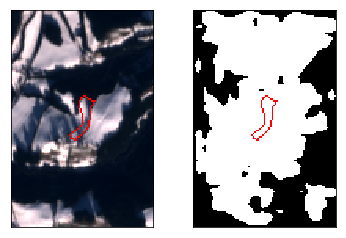

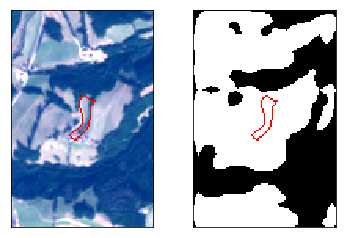

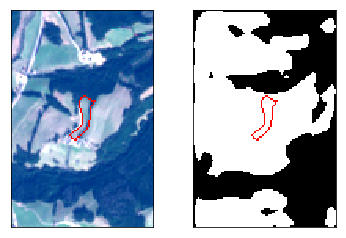

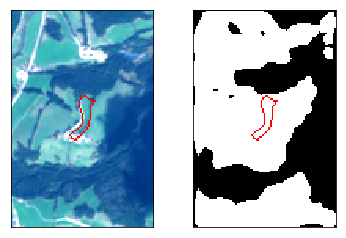

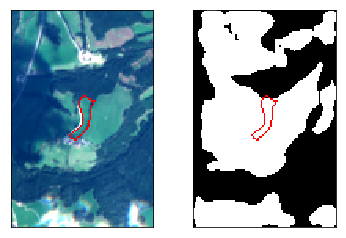

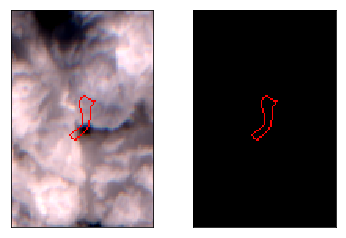

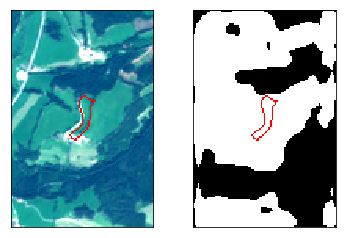

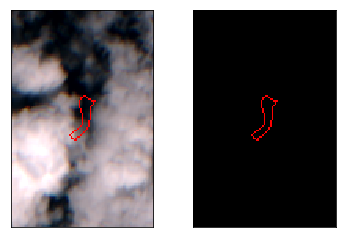

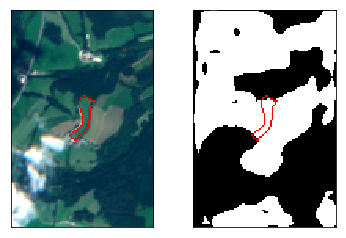

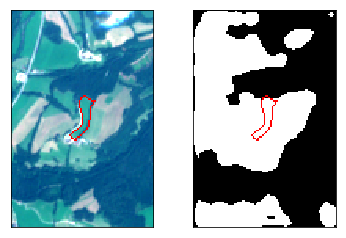

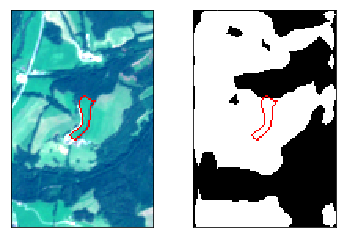

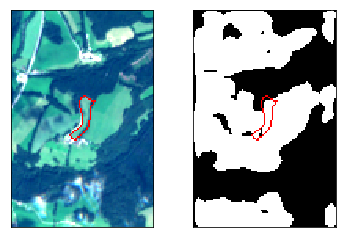

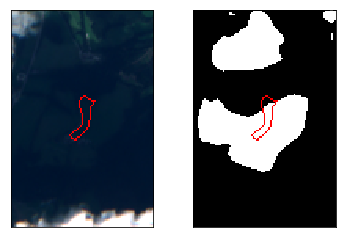

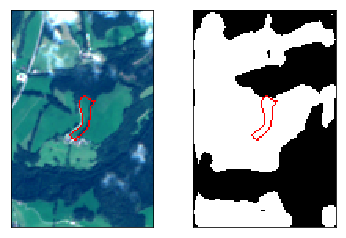

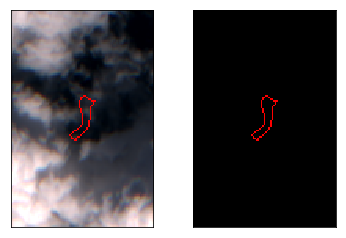

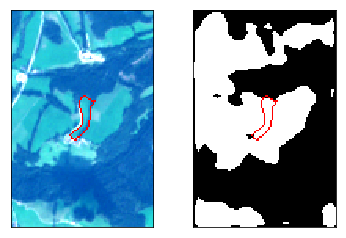

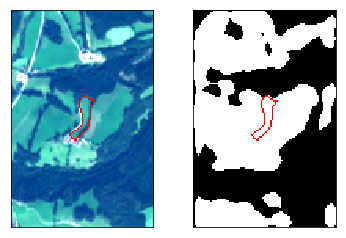

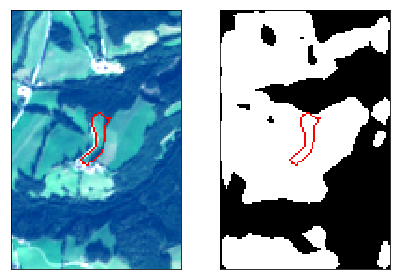

In [10]:
# Overlay the polygon by rasterising it:
bbox_poly = patch.bbox.get_geometry()
geomtrie = patch.vector_timeless['polygon']
filtered_data = geomtrie[geomtrie.intersects(bbox_poly)].copy(deep=True)
filtered_data.geometry = filtered_data.geometry.intersection(bbox_poly).exterior
height, width = patch.get_spatial_dimension(FeatureType.MASK, 'IS_DATA')
data_transform = rasterio.transform.from_bounds(*patch.bbox, width=width, height=height)
raster = np.zeros_like(patch.mask['IS_DATA'][0].squeeze()).astype(np.uint8)
rasterio.features.rasterize([(filtered_data.cascaded_union, 255)], out=raster, transform=data_transform, dtype=np.uint8)

nb_images = patch.data['BANDS-S2-L1C'].shape[0]
for i in range(nb_images):
    plt.figure()
    ax = plt.subplot(1, 2,1)
    image = normalize_percentile(patch.data['BANDS-S2-L1C'][i,:,:,[3,2,1]].transpose((1,2,0)), 2)
    image[raster == 255] = [255, 0, 0]
    ax.imshow(image)
    plt.xticks([])
    plt.yticks([])

    ax = plt.subplot(1, 2, 2)
    mask = patch.mask['MODEL_EVAL'][i]
    mask[raster == 255] = [255, 0, 0]
    ax.imshow(mask)
    plt.xticks([])
    plt.yticks([])
fig.subplots_adjust(wspace=0.01, hspace=0.01)
plt.tight_layout()
plt.show()

And finally:

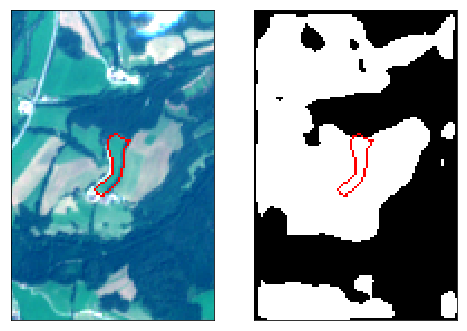

Found Field type : <Field> 


In [11]:
plt.figure(figsize=(8,20))

ax = plt.subplot(1, 2, 1)
image = normalize_percentile(patch.data['BANDS-S2-L1C'][9,:,:,[3,2,1]].transpose((1,2,0)), 2)
image[raster == 255] = [255, 0, 0]
ax.imshow(image)
plt.xticks([])
plt.yticks([])

ax = plt.subplot(1, 2, 2)
mask = patch.mask_timeless['ALL-TIME_PREDICTION_MASK']
mask[raster == 255] = [255, 0, 0]
ax.imshow(mask)
plt.xticks([])
plt.yticks([])
plt.show()
print('Found Field type : <%s> '%(patch.meta_info['FOUND_LABEL']))

We can see that the field is correctly detected. 

We can also verify that our algorithm works by translating the polygon to the forest area on the right of the image to see if the algorithm correctly predicts the "background" type.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: FeatureType.MASK_TIMELESS is a discrete feature type therefore dtype of data should be a subtype of numpy.integer or numpy.bool, found type <class 'numpy.float64'>. In the future an error will be raised becauseof this
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: FeatureType.MASK_TIMELESS is a discrete feature type therefore dtype of data should be a subtype of numpy.integer or numpy.bool, found type <class 'numpy.float64'>. In the future an error will be raised becauseof this


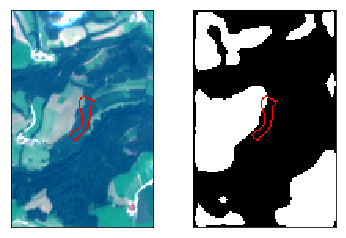

Found Field type : <Background> 


In [12]:
patch = workflow.execute({
            init_task: {'polygon': polygon.translate(xoff=0.004)}
        })
for x in patch.keys():
    patch = patch[x]
plt.figure()

ax = plt.subplot(1, 2, 1)
image = normalize_percentile(patch.data['BANDS-S2-L1C'][9,:,:,[3,2,1]].transpose((1,2,0)), 2)
image[raster == 255] = [255, 0, 0]
ax.imshow(image)
plt.xticks([])
plt.yticks([])

ax = plt.subplot(1, 2, 2)
mask = patch.mask_timeless['ALL-TIME_PREDICTION_MASK']
mask[raster == 255] = [255, 0, 0]
ax.imshow(mask)
plt.xticks([])
plt.yticks([])
plt.show()
print('Found Field type : <%s> '%(patch.meta_info['FOUND_LABEL']))

# 3.Statistics
We showed that the alogithm can be used to classify polygons into fields/background. We now would like to know which performance to expect from the algorithm.

To do so, we need to extract all cultivated areas around a polygon in order to compute per_pixel metrics on the whole preditcion

In [13]:
import ogr
import shapely
import rasterio

class RasterizeInsideBBox(EOTask):
    def __init__(self, ogr_shapefile, feature_name, raster_value):
        self.raster_value = raster_value
        self.shapes = ogr.Open(ogr_shapefile)
        self.ogr_layer = self.shapes.GetLayer()
        self.feature_name = feature_name
        
    def execute(self, eopatch):
        geom_bounding_box = ogr.CreateGeometryFromWkt(eopatch.bbox.wkt)
        self.ogr_layer.SetSpatialFilter(geom_bounding_box)
        union_poly = ogr.Geometry(ogr.wkbPolygon)
        # make the union of polygons
        for feature in self.ogr_layer:
              geom = feature.GetGeometryRef()
              union_poly = union_poly.Union(geom)
        fields = shapely.wkt.loads(union_poly.ExportToWkt())
        height, width = eopatch.get_spatial_dimension(FeatureType.MASK, 'IS_DATA')
        data_transform = rasterio.transform.from_bounds(*eopatch.bbox, width=width, height=height)

        raster = np.zeros_like(eopatch.mask['IS_DATA'][0].squeeze()).astype(np.uint8)
        rasterio.features.rasterize([(fields, self.raster_value)], out=raster, transform=data_transform, dtype=np.uint8)
        eopatch[FeatureType.MASK_TIMELESS][self.feature_name] = raster[:,:,None]
        return eopatch

rasterize_all_poly_task = RasterizeInsideBBox('../../PerSenDatasetEval/input_data/INSPIRE_SCHLAEGE_2016.shp', 'GT_MASK', 255)

In [14]:
rasterize_all_poly_task.execute(patch)

EOPatch(
  data: {
    BANDS-S2-L1C: numpy.ndarray(shape=(18, 139, 91, 13), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(18, 139, 91, 1), dtype=bool)
    MODEL_EVAL: numpy.ndarray(shape=(18, 139, 91, 3), dtype=uint8)
    MODEL_EVAL_CLASS: numpy.ndarray(shape=(18, 139, 91, 1), dtype=uint8)
    MODEL_EVAL_PROBA: numpy.ndarray(shape=(18, 139, 91, 1), dtype=uint8)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    ALL-TIME_PREDICTION: numpy.ndarray(shape=(139, 91, 1), dtype=float64)
    ALL-TIME_PREDICTION_MASK: numpy.ndarray(shape=(139, 91, 3), dtype=uint8)
    ALL-TIME_PREDICTION_PROBA: numpy.ndarray(shape=(139, 91, 1), dtype=float64)
    CLASS_MASK: numpy.ndarray(shape=(139, 91, 1), dtype=uint8)
    GT_MASK: numpy.ndarray(shape=(139, 91, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    polygon: geopandas.GeoDataFrame(columns=['geometry'], length=1, crs=epsg:4326)
  }
  meta_info: {
    FOUND_LABE

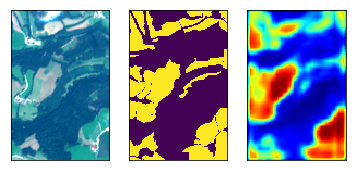

In [15]:
plt.figure()

ax = plt.subplot(1, 3, 1)
image = normalize_percentile(patch.data['BANDS-S2-L1C'][9,:,:,[3,2,1]].transpose((1,2,0)), 2)
ax.imshow(image)
plt.xticks([])
plt.yticks([])

ax = plt.subplot(1, 3, 2)
image = patch.mask_timeless['GT_MASK'][:,:,0]
ax.imshow(image)
plt.xticks([])
plt.yticks([])

ax = plt.subplot(1, 3, 3)
# mask = patch.mask_timeless['ALL-TIME_PREDICTION_MASK']
mask = patch.mask_timeless['ALL-TIME_PREDICTION_PROBA'][:,:,0]/255
ax.imshow(mask, cmap='jet')
plt.xticks([])
plt.yticks([])
plt.show()

To extract the best mask out of our predictions we can compute the ROC curve to find the best threshold for our prediction:

In [16]:
from sklearn import metrics
scores = patch.mask_timeless['ALL-TIME_PREDICTION_PROBA'].flatten() / 255
y = (patch.mask_timeless['GT_MASK'].flatten() / 255).astype(int)
fpr, tpr, thresholds = metrics.roc_curve(y, scores)

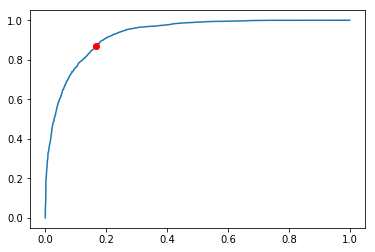

Best threshold= 0.27450980392156865


In [17]:
best = np.stack([fpr, tpr], 1)
best[:,1] -= 1
best = np.argmin(np.linalg.norm(best, axis=1))

plt.figure()
plt.plot(fpr, tpr)
plt.plot(fpr[best], tpr[best], 'or')
plt.show()

print('Best threshold=', thresholds[best])

And finaly, we can extract a predicted cultivated area with the associated precision and recall:

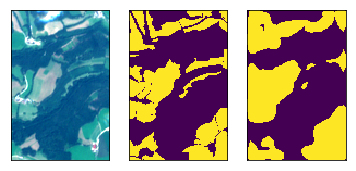

In [18]:
thresh = thresholds[best]*255
final_prediction = np.zeros_like(patch.mask_timeless['ALL-TIME_PREDICTION_PROBA'])
final_prediction[patch.mask_timeless['ALL-TIME_PREDICTION_PROBA']>thresh] = 1

plt.figure()
ax = plt.subplot(1, 3, 1)
image = normalize_percentile(patch.data['BANDS-S2-L1C'][9,:,:,[3,2,1]].transpose((1,2,0)), 2)
ax.imshow(image)
plt.xticks([])
plt.yticks([])

ax = plt.subplot(1, 3, 2)
image = patch.mask_timeless['GT_MASK'][:,:,0]
ax.imshow(image)
plt.xticks([])
plt.yticks([])

ax = plt.subplot(1, 3, 3)
# mask = patch.mask_timeless['ALL-TIME_PREDICTION_MASK']
mask = final_prediction[:,:,0]
ax.imshow(mask)
plt.xticks([])
plt.yticks([])
plt.show()

In [19]:
scores = metrics.precision_recall_fscore_support(patch.mask_timeless['GT_MASK'].flatten(), final_prediction.flatten())
print('Precision=',scores[0][0])
print('Recall=',scores[1][0])

Precision= 0.9095278484591461
Recall= 0.8341760663814339


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Mean performances

The previous methods are now used on more than one data in order to get the better metrics of our alorithm

In [20]:
from eolearn.core import LinearWorkflow

workflow = LinearWorkflow(init_task,
                           input_task,
                           eval_task,
                           prediction_task,
                           rasterize_gt_task,
                           extract_field_task,
                           rasterize_all_poly_task) 

nb_of_polygons = 300
result = []
index = np.random.permutation(list(range(len(austria_lpis_2016))))
list_scores = []
list_y = []
for i in index[:nb_of_polygons]:
    polygon = austria_lpis_2016[i:i+1]
    patch = workflow.execute({
                init_task: {'polygon': polygon}
            })
    for x in patch.keys():
        patch = patch[x]
        
    list_scores.append(patch.mask_timeless['ALL-TIME_PREDICTION_PROBA'].flatten() / 255)
    list_y.append((patch.mask_timeless['GT_MASK'].flatten() / 255).astype(int))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: FeatureType.MASK_TIMELESS is a discrete feature type therefore dtype of data should be a subtype of numpy.integer or numpy.bool, found type <class 'numpy.float64'>. In the future an error will be raised becauseof this
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: FeatureType.MASK_TIMELESS is a discrete feature type therefore dtype of data should be a subtype of numpy.integer or numpy.bool, found type <class 'numpy.float64'>. In the future an error will be raised becauseof this


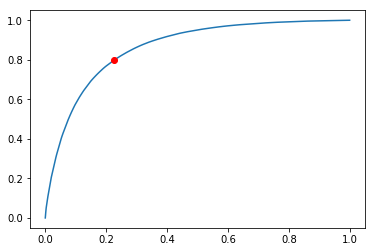

Best threshold= 0.43012477718360076


In [21]:
scores = np.concatenate(list_scores)
y = np.concatenate(list_y)
fpr, tpr, thresholds = metrics.roc_curve(y, scores)

best = np.stack([fpr, tpr], 1)
best[:,1] -= 1
best = np.argmin(np.linalg.norm(best, axis=1))

plt.figure()
plt.plot(fpr, tpr)
plt.plot(fpr[best], tpr[best], 'or')
plt.show()

print('Best threshold=', str(thresholds[best]))

We can now compute the mean precision and recall:

In [23]:
from eolearn.core import LinearWorkflow

workflow = LinearWorkflow(init_task,
                           input_task,
                           eval_task,
                           prediction_task,
                           rasterize_gt_task,
                           extract_field_task,
                           rasterize_all_poly_task) 

nb_of_polygons = 100
result = []
index = np.random.permutation(list(range(len(austria_lpis_2016))))
list_pred = []
list_gt = []
for i in index[:nb_of_polygons]:
    polygon = austria_lpis_2016[i:i+1]
    patch = workflow.execute({
                init_task: {'polygon': polygon}
            })
    for x in patch.keys():
        patch = patch[x]
         
    thresh = thresholds[best]*255
    final_prediction = np.zeros_like(patch.mask_timeless['ALL-TIME_PREDICTION_PROBA'])
    final_prediction[patch.mask_timeless['ALL-TIME_PREDICTION_PROBA']>thresh] = 1
    
    list_pred.append(final_prediction.flatten())
    list_gt.append((patch.mask_timeless['GT_MASK'].flatten() / 255).astype(int))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: FeatureType.MASK_TIMELESS is a discrete feature type therefore dtype of data should be a subtype of numpy.integer or numpy.bool, found type <class 'numpy.float64'>. In the future an error will be raised becauseof this
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: FeatureType.MASK_TIMELESS is a discrete feature type therefore dtype of data should be a subtype of numpy.integer or numpy.bool, found type <class 'numpy.float64'>. In the future an error will be raised becauseof this


In [24]:
scores = metrics.precision_recall_fscore_support(np.concatenate(list_gt), np.concatenate(list_pred))
print('Precision=',scores[0][0])
print('Recall=',scores[1][0])

Precision= 0.7878181075879231
Recall= 0.7429687213523524
